# Clip scenes

## Introduction

In [Section 1](#clip) of this notebook, we clip raw Landsat data to the New York City boundary. We clip only the band numbers that are needed for land surface temperature (LST) and normalized-difference vegetation index (NDVI) calculations. The bands are summarized in the following table.

|Satellite| Bands|
|---------|------|
|Landsat 5| 3, 4, and 6|
|Landsat 8| 4, 5, and 10|

In [Section 2](#plot) We plot the clipped raw data. 

**NOTE**: User must change the `DIR_HD` variable to the folder holding the raw Landsat data. 

## Results

If the Landsat files have already been clipped, they can be plotted in [Section 2](#plot) of this notebook. 

## Data

Data imported into this notebook is 

- Raw Landsat data stored on an external harddrive. This is raster data. 
- A shapefile from the `02-data/boundaries/` folder containing the NYC boundary

Results are exported to `02-data/landsat_clipped_nyc`. 

In [2]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""
CHANGE HERE: DIR_HD refers to the location of the harddrive
"""
DIR_HD = "/run/media/aderrasc/nasa" # Harddrive location

"""
Push scripts directory to load helpers from
"""
import sys
sys.path.append(DIR_SCRIPTS)

import helpers

import geopandas as gpd
import rioxarray as rxr
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# Import directories
DIR_RAW_DATA = DIR_HD + "/landsat_raw"
DIR_DATA = DIR_PARENT + "/02-data"
DIR_BOUNDARIES = DIR_DATA + "/boundaries"
DIR_BOUNDARIES_NYC_BOROS =  DIR_BOUNDARIES + "/nyc_boroughs"

# Export directories
DIR_CLIPPED_NYC = DIR_PARENT + "/02-data/landsat_clipped_nyc"
DIR_FIGS = DIR_PARENT + "/03-figs"

### 1. Clip raw Landsat files <a id="clip"></a>

In [ ]:
landsat_filenames = []
helpers.get_filenames(DIR_RAW_DATA, landsat_filenames)
landsat_filenames

filenames_to_clip = [x for x in landsat_filenames \
                     if ("B3" in x and "LT05" in x) or \
                     ("B4" in x and "LT05" in x) or \
                     ("B6" in x and "LT05" in x) or \
                     ("B4" in x and "LC08" in x) or \
                     ("B5" in x and "LC08" in x) or \
                     ("B10" in x and "LC08" in x)]

# Import the NYC shapefile. This will be used to clip.
boundary_nyc = gpd.read_file(DIR_BOUNDARIES_NYC_BOROS + "/nybb.shp")

# Get the CRS of landsat data by importing and calling the CRS function
crs_landsat = rxr.open_rasterio(filenames_to_clip[0], masked=True).rio.crs

# Converty the CRS of the boundary to the CRS of the Landsat data
boundary_nyc = boundary_nyc.to_crs(crs_landsat)

In [ ]:
"""Run this cell to clip Landsat data. Skip to the next cell to import clipped
data."""
for fname in filenames_to_clip:
    export_name = DIR_CLIPPED_NYC + "/clipped_nyc_" + fname.split("/")[-1]
    helpers.clip_and_export(fname, boundary_nyc["geometry"], export_name) 

### 2. Plot clipped Landsat files <a id="plot"></a>

In [3]:
clipped_landsat_filenames = []
helpers.get_filenames(DIR_CLIPPED_NYC, clipped_landsat_filenames)
clipped_landsat_filenames = [x for x in clipped_landsat_filenames \
                             if ".TIF" in x]
clipped_landsat_filenames.sort()
print("Number of clipped files = ", len(clipped_landsat_filenames))

Number of clipped files =  354


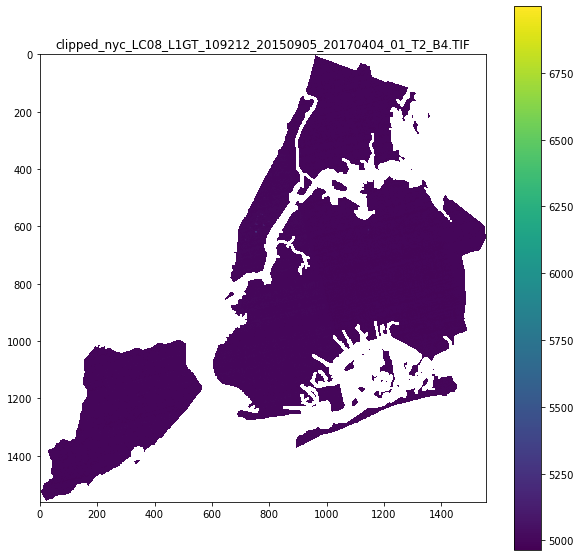

In [4]:
select_file = 10

#####################################
fname = clipped_landsat_filenames[select_file]
ras = rxr.open_rasterio(fname, dtype=np.float32, masked=True).squeeze()
ras_masked = ras.where(ras != -0.0) 
ras_masked = ras_masked.where(ras_masked != -9999.0) 

fig = plt.figure(figsize=(10, 10))
plt.imshow(ras_masked)#,vmin=-1,vmax=1)
plt.colorbar()
plt.title(fname.split("/")[-1])
# plt.savefig(DIR_FIGS+"/zoom_"+fname.split("/")[-1][:-4]+".png")
plt.show()